In [1]:
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import scipy as sp
import scipy.integrate as spi
import scipy.linalg as spl
import scipy.stats as sps
import scipy.optimize as spo
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from scipy.linalg import expm

# Function definitions

In [2]:
def random_density_matrix(dim):
    """
    Generate a random density matrix of dimension `dim`.
    The resulting matrix is Hermitian, positive semidefinite, and has trace 1.
    """
    matrix = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)

    matrix = (matrix + matrix.conj().T) / 2
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    eigenvalues = np.abs(eigenvalues)
    eigenvalues /= np.sum(eigenvalues)

    density_matrix = np.dot(eigenvectors * eigenvalues, eigenvectors.conj().T)

    return density_matrix

def random_hermite(n):
    """
    Generate a random Hermitian (self-adjoint) matrix of size n x n.
    """
    real_part = np.random.rand(n, n)
    imag_part = np.random.rand(n, n)
    A = real_part + 1j * imag_part

    H = (A + A.conj().T) / 2

    return H

def random_unitary(n):
    """
    Generate a random unitary matrix of size n x n,
    distributed according to the Haar measure.
    """
    U = unitary_group.rvs(n)
    return U

def gibbs_state(H, beta):
    """
    Compute the Gibbs (thermal) state for Hamiltonian H and inverse temperature beta.
    Returns the density matrix: exp(-beta*H) / Tr[exp(-beta*H)]
    """
    exp_neg_beta_H = expm(-beta * H)
    Z = np.trace(exp_neg_beta_H)
    rho = exp_neg_beta_H / Z
    return rho

def eigenvalues(A):
    """
    Return the eigenvalues of matrix A.
    """
    return npl.eigvals(A)

def energy_bandwidth(H):
    """
    Compute the energy bandwidth of a Hamiltonian H:
    max(E) - min(E), where E are eigenvalues of H.
    """
    evs = np.real(eigenvalues(H))
    return np.max(evs) - np.min(evs)

def zero_standard_random_hermite(n):
    """
    Generate a random Hermitian matrix with its smallest eigenvalue shifted to zero.
    """
    G = random_hermite(n)
    evs = np.real(eigenvalues(G))
    min_evs = np.min(evs)
    return G - min_evs * np.eye(n)

def TrS(rho, dim_H1, dim_H2):
    """
    Compute the partial trace over the first subsystem (of dimension dim_H1)
    for a bipartite density matrix rho of shape (dim_H1*dim_H2, dim_H1*dim_H2).
    Returns the reduced density matrix on the second subsystem.
    """
    reshaped_rho = rho.reshape(dim_H1, dim_H2, dim_H1, dim_H2)
    reduced_rho = np.trace(reshaped_rho, axis1=0, axis2=2)
    return reduced_rho

def expectation(rho, G):
    """
    Compute the expectation value of observable G in state rho: Tr(rho G).
    """
    return np.trace(rho @ G).real

def variance(rho, G):
    """
    Compute the variance of observable G in state rho:
    Var(G) = <G^2> - <G>^2
    """
    return (expectation(rho, G@G) - expectation(rho, G)**2).real

# Fundamental precision limit 1
Codes to recreate Fig. S3(a) in the Supplementary Material.
The codes verify the following precision limt.
$$
\frac{\operatorname{Var}[G]}{\mathbb{E}[G]^2} \geq\left(\frac{d_E e^{\beta \Delta \epsilon}}{d_S \lambda_{\min }\left(\rho_S\right)}-1\right)^{-1}
$$

In [6]:
def random_case_GE(dS, dE, beta = 0.1):
    """
    Run a random case for the fundamental precision limit 1
    """
    rhoS = random_density_matrix(dS)
    HE = random_hermite(dE)
    rhoE = gibbs_state(HE, beta)

    U = random_unitary(dS * dE)
    rhoSE = np.kron(rhoS, rhoE)
    rhoE_dash = TrS(U @ rhoSE @ U.conj().T, dS, dE)
    G = zero_standard_random_hermite(dE)

    evS = np.real(eigenvalues(rhoS))
    d_epsilon = energy_bandwidth(HE)

    tmp = dE * np.exp(beta * d_epsilon) / (dS * np.min(evS)) - 1

    return variance(rhoE_dash, G)/expectation(rhoE_dash, G)**2, 1 / tmp

In [7]:
rr = np.array([random_case_GE(npr.randint(2, 3), npr.randint(2, 5), beta = 10**npr.uniform(-2, 1)) for _ in range(1000)])

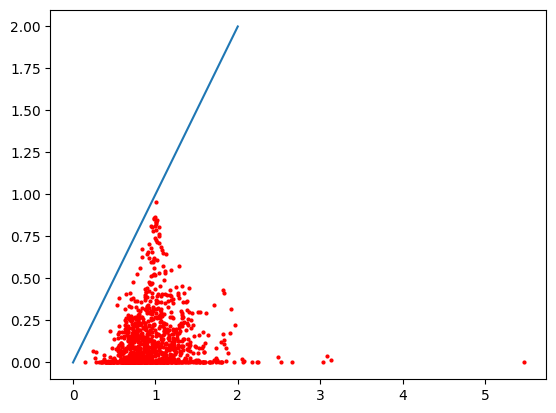

In [8]:
plt.scatter(rr[:, 0], rr[:, 1], s=4, color='red')
xs = np.linspace(0, 2)
plt.plot(xs, xs)

# Fundamental precision limit 2
Codes to recreate Fig. S3(b) in the Supplementary Material.
The codes verify the following precision limt.
$$
\mathbb{E}[G] \leq \lambda_{\max }[G]\left(1-\frac{d_S \lambda_{\min }\left(\rho_S\right)}{d_E e^{\beta \Delta \epsilon}}\right)
$$

In [13]:
def random_case_expectation_GE(dS, dE, beta = 0.1):
    """
    Run a random case for the fundamental precision limit 2
    """
    rhoS = random_density_matrix(dS)
    HE = random_hermite(dE)
    rhoE = gibbs_state(HE, beta)

    U = random_unitary(dS * dE)
    rhoSE = np.kron(rhoS, rhoE)
    rhoE_dash = TrS(U @ rhoSE @ U.conj().T, dS, dE)
    G = zero_standard_random_hermite(dE)

    evS = np.real(eigenvalues(rhoS))
    d_epsilon = energy_bandwidth(HE)

    G_eigmax = np.max(eigenvalues(G).real)

    tmp = G_eigmax * (1 - dS * np.min(evS) / (dE * np.exp(beta * d_epsilon)))

    return expectation(rhoE_dash, G), tmp

In [14]:
rr = np.array([random_case_expectation_GE(npr.randint(2, 3), npr.randint(2, 5), beta = 10**npr.uniform(-2, 1)) for _ in range(1000)])

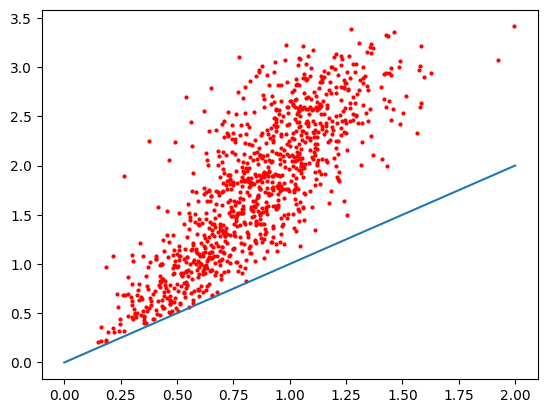

In [15]:
plt.scatter(rr[:, 0], rr[:, 1], s=4, color='red')
xs = np.linspace(0, 2)
plt.plot(xs, xs)